<a href="https://colab.research.google.com/github/TivoGatto/Thesis/blob/master/InfoVAE/InfoVAE_MNIST_change_lambda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda
from keras.datasets import mnist
import keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Parameters
input_dim = (32, 32, 1)
latent_dim = 16

epochs = 150
batch_size = 100

initial_lr = 1e-4
halve_at_epoch = 100

alpha = 0.8
lams = [1, 10, 100]

TRAIN = True

In [ ]:
# ADDITIONAL FUNCTIONS
def vae_loss(z_mean, z_log_var, z_true, z_gen):
    def loss(x_true, x_pred):
        x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
        x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

        xent_loss = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        reg_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1) # E_x[DKL(q(z|x) || p(z))]
        mmd_loss = compute_mmd(z_true, z_gen)

        return K.mean(xent_loss + (1 - alpha) * reg_loss) + (alpha + lam - 1) * mmd_loss   # MMD(q(z) || p(z))
    return loss

def recon(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def KL(z_mean, z_log_var):
    def loss(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))
    return loss

def mmd_loss(x_true, x_pred):
    return compute_mmd(z_true, z_gen)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))

    return z_mean + epsilon * K.exp(0.5 * z_log_var)

def compute_kernel(x, y):
    x_size = batch_size
    y_size =  x_size

    dim     = K.int_shape(x)[1]
    tiled_x = K.tile(K.reshape(x, K.stack([x_size, 1, dim])), K.stack([1, y_size, 1])) 
    tiled_y = K.tile(K.reshape(y, K.stack([1, y_size, dim])), K.stack([x_size, 1, 1]))
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

    return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel) 

def pad(x, d):
    size = x.shape[0]
    h, w = x.shape[1:]

    x = np.reshape(x, (size, h, w, 1))

    x_padded = np.zeros(shape=(size, ) + d)
    x_padded[:, :h, :w] = x

    return x_padded

In [ ]:
# DATASET
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = pad(x_train, input_dim) / 255 # For MNIST, we pad x_train and x_test in 
x_test  = pad(x_test, input_dim) / 255 # shape (32, 32, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('Train Shape: ', x_train.shape)
print('Test Shape: ', x_test.shape)

Train Shape:  (60000, 32, 32, 1)
Test Shape:  (10000, 32, 32, 1)


In [ ]:
for i in range(len(lams)):
    # Model Architecture
    # ENCODER
    x = Input(shape=input_dim) # Shape (32, 32, 1)

    h = Conv2D(32, 4, strides=(2, 2), padding='same')(x) # Shape (16, 16, 32)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Conv2D(64, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 64)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Conv2D(128, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 128)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Flatten()(h)

    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(x, [z, z_mean, z_log_var])

    # DECODER
    z_in = Input(shape=(latent_dim, ))

    h = Dense(4 * 4 * 128)(z_in)
    h = Reshape((4, 4, 128))(h)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Conv2DTranspose(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Conv2DTranspose(64, 4, strides=(2, 2), padding='same')(h) # Shape (16, 16, 64)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    h = Conv2DTranspose(32, 4, strides=(2, 2), padding='same')(h) # Shape (32, 32, 32)
    h = BatchNormalization()(h)
    h = ReLU()(h)

    x_decoded = Conv2DTranspose(1, 4, strides=(1, 1), padding='same', activation='sigmoid')(h) # Shape (32, 32, 1)

    decoder = Model(z_in, x_decoded)

    # Generate z samples
    z_true = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
    z_gen  = encoder(x)[0]

    # VAE
    x_recon = decoder(z)

    vae = Model(x, x_recon)

    # Compile model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
    steps_per_epoch = 54000 / batch_size
    lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch], [initial_lr, initial_lr/2])
    optimizer = Adam(learning_rate=lr_schedule)

    lam = lams[i]
    # Fit model
    vae.compile(optimizer=optimizer, loss=vae_loss(z_mean, z_log_var, z_true, z_gen), metrics=[recon, KL(z_mean, z_log_var)])
    hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

    loss = hist.history['loss']
    recon = hist.history['recon']
    loss_1 = hist.history['loss_1']

    val_loss = hist.history['val_loss']
    val_recon = hist.history['val_recon']
    val_loss_1 = hist.history['val_loss_1']

    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, loss_1, val_loss, val_recon, val_loss_1])
    savetxt('InfoVAE_MNIST_lambda_'+str(lam)+'.csv', data, delimiter=',')

    vae.save_weights('InfoVAE_MNIST_lambda_'+str(lam)+'.h5')

Train on 54000 samples, validate on 6000 samples
Epoch 1/150
53900/54000 [============================>.] - ETA: 0s - loss: 22.4664 - recon: 19.2542 - loss_1: 15.9795WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
54000/54000 [==============================] - 27s 494us/sample - loss: 22.4482 - recon: 19.2352 - loss_1: 15.9835 - val_loss: 13.4093 - val_recon: 9.4763 - val_loss_1: 19.6334
Epoch 2/150
54000/54000 [==============================] - 26s 485us/sample - loss: 12.1405 - recon: 8.2000 - loss_1: 19.6852 - val_loss: 11.3834 - val_recon: 7.3038 - val_loss_1: 20.3829
Epoch 3/150
54000/54000 [==============================] - 26s 489us/sample - loss: 11.1152 - recon: 7.0055 - loss_

In [ ]:
if TRAIN:
    for i in range(len(lams)):

# Save training history

In [ ]:
if TRAIN:
    loss = hist.history['loss']
    recon = hist.history['recon']
    loss_1 = hist.history['loss_1']

    val_loss = hist.history['val_loss']
    val_recon = hist.history['val_recon']
    val_loss_1 = hist.history['val_loss_1']

    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, loss_1, val_loss, val_recon, val_loss_1])
    savetxt('InfoVAE_MNIST.csv', data, delimiter=',')

    vae.save_weights('InfoVAE_MNIST.h5')
else:
    vae.load_weights('InfoVAE_MNIST.h5')

# Generation and Reconstruction

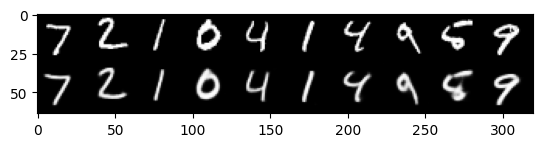

In [ ]:
# Reconstruction
n = 10
digit_size = input_dim[0]

x_recon = vae.predict(x_test, batch_size=batch_size)
x_recon = np.reshape(x_recon, (-1, digit_size, digit_size))
x_test = np.reshape(x_test, (-1, digit_size, digit_size))
figure = np.zeros((2 * digit_size, n * digit_size))

for i in range(n):
    figure[:digit_size, i * digit_size: (i+1) * digit_size] = x_test[i]
    figure[digit_size:, i * digit_size: (i+1) * digit_size] = x_recon[i]

x_test = np.reshape(x_test, (-1, ) + input_dim)

plt.style.use('default')
plt.imshow(figure, cmap='gray')
plt.savefig('InfoVAE_MNIST_reconstruction.png')
plt.show()

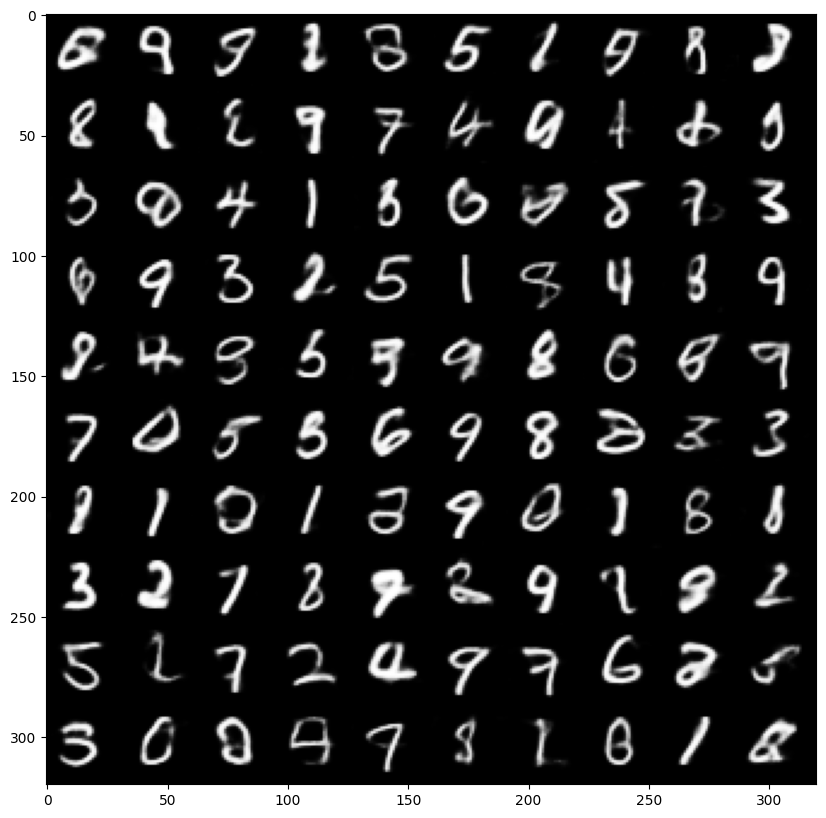

In [ ]:
# Generation
n = 10 #figure with n x n digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points randomly sampled

z_sample = np.random.normal(size=(n**2, latent_dim), scale=1)
for i in range(n):
    for j in range(n):
        x_decoded = decoder.predict(np.array([z_sample[i + n * j]]))
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.savefig('InfoVAE_MNIST_generation.png')
plt.show()

# Interpolation

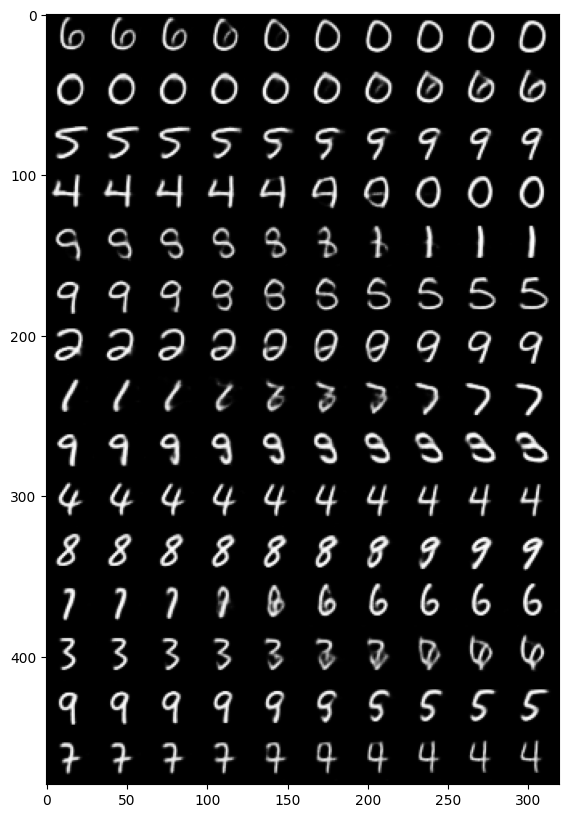

In [ ]:
T = 10
N = 15

s = 10
k = 100

X_final = [0] * N
for n in range(N):
    x_a = x_test[n + s]
    x_b = x_test[n + k]

    z_a = encoder.predict(np.reshape(x_a, (1, 32, 32, 1)))[0]
    z_b = encoder.predict(np.reshape(x_b, (1, 32, 32, 1)))[0]


    X = [0] * T
    for i in range(T):
        t = i/T
        z = t * z_a + (1 - t) * z_b

        X[i] = decoder.predict(z)
    
    X_final[n] = X

digit_size = 32
figure = np.zeros((N * digit_size, T * digit_size))
for n in range(N):
    for i in range(T):
        figure[n * digit_size : (n+1) * digit_size, i * digit_size : (i+1) * digit_size] = X_final[n][i][0, :, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.savefig('InfoVAE_MNIST_interpolation.png')
plt.show()

# Nearest Neaighbour

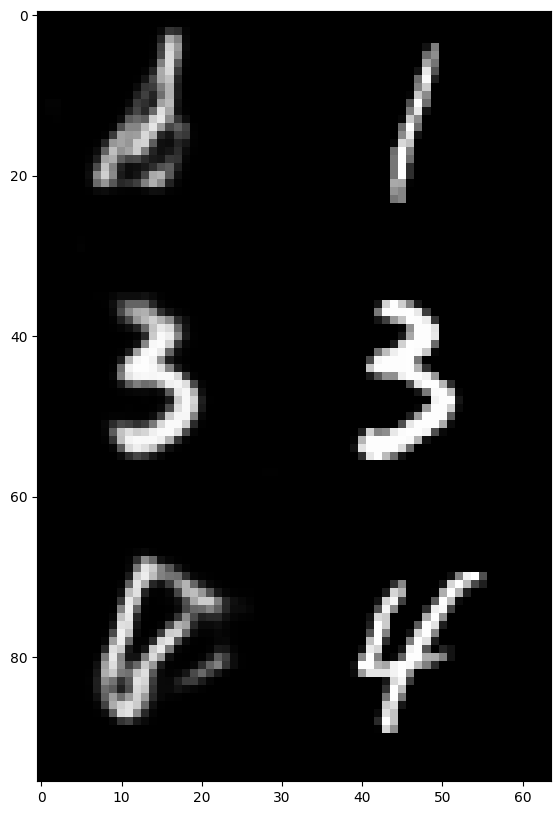

In [ ]:
# We want to investigate overfitting
def get_distance(x, y_vec):
    digit_size = x.shape[0]
    x = np.reshape(x, (digit_size**2, ))
    y_vec = np.reshape(y_vec, (-1, digit_size**2, ))

    res = np.zeros((y_vec.shape[0], ))
    for j in range(y_vec.shape[0]):
        res[j] = np.mean(np.square(x - y_vec[j]))

    return res

N = 3 # Images we need to check
digit_size = 32
z = np.random.normal(size=(N, latent_dim))
x_gen = decoder.predict(z)
figure = np.zeros((N * digit_size, 2 * digit_size))
for i in range(N):
    x = x_gen[i]
    distances = get_distance(x, x_train)
    m = np.min(distances)
    i_m = np.argmin(distances)

    figure[i * digit_size : (i+1) * digit_size, : digit_size] = x[:, :, 0]
    figure[i * digit_size : (i+1) * digit_size, digit_size :] = x_train[i_m][:, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.savefig('InfoVAE_MNIST_NN.png')
plt.show()

# Metrics Evaluation

First of all, we want to evaluate the ability of the model of generate high quality samples.

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
#from keras.applications.inception_v3 import preprocess_input
#from skimage.transform import resize
#from tensorflow.keras.models import load_model
#import os
#from matplotlib import pyplot

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    n_batches = inps.shape[0]//batch_size
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * batch_size:(i + 1) * batch_size]
        inpr = tf.image.resize(inp, (299, 299))
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr,steps=1)
        
        print('Processed ' + str((i+1) * batch_size) + ' images.')
    return act

def get_fid(images1, images2):
    print(images1.shape)
    print(images2.shape)
    print(type(images1))
    # calculate activations
    act1 = get_inception_activations(images1,batch_size=100)
    #print(np.shape(act1))
    act2 = get_inception_activations(images2,batch_size=100)
    # compute mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

z_sample = np.random.normal(0, 1, size=(x_test.shape[0], latent_dim))
x_gen = decoder.predict(z_sample)
x_gens = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
x_tests = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
for i in range(3):
	x_gens[:, :, :, i] = x_gen[:, :, :, 0]
	x_tests[:, :, :, i] = x_test[:, :, :, 0]

fid = get_fid(x_tests, x_gens)
print('\n FID: %.3f' % fid)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processed 3900 images.
Processed 4000 images.
Processed 4100 images.
Proc

### Deactivated Latent Variables, Variance Loss and Variance Law


In [ ]:
def count_deactivated_variables(z_var, treshold = 0.8):
    z_var = np.mean(z_var, axis=0)

    return np.sum(z_var > treshold)

def loss_variance(x_true, x_recon):
    x_true = np.reshape(x_true, (-1, np.prod(x_true.shape[1:])))
    x_recon = np.reshape(x_recon, (-1, np.prod(x_recon.shape[1:])))

    var_true = np.mean(np.var(x_true, axis=1), axis=0)
    var_recon = np.mean(np.var(x_recon, axis=1), axis=0)

    return np.abs(var_true - var_recon)

########################################################################################################################
# SHOW THE RESULTS
########################################################################################################################

_, z_mean, z_log_var = encoder.predict(x_test, batch_size=batch_size)
z_var = np.exp(z_log_var)
n_deact = count_deactivated_variables(z_var)
print('We have a total of ', latent_dim, ' latent variables. ', count_deactivated_variables(z_var), ' of them are deactivated')

var_law = np.mean(np.var(z_mean, axis=0) + np.mean(z_var, axis=0))
print('Variance law has a value of: ', var_law)

x_recon = vae.predict(x_train, batch_size=batch_size)
print('We lost ', loss_variance(x_test, x_recon), 'Variance of the original data')

We have a total of  16  latent variables.  0  of them are deactivated
Variance law has a value of:  0.9924071
We lost  0.008746706 Variance of the original data


### Latent space matching

In [ ]:
# We want to verify if q(z) = p(z).

# Moments Matching
# Generate samples from q(z) and for p(z)
# p(z) = N(0, I)
# q(z) = E_q(x)[q(z|x)]
#
# For every moment we compare the moments
n = len(x_test)

p_samples = np.random.normal(size=(n, latent_dim))
q_samples = encoder.predict(x_test, batch_size=batch_size)[0]


from scipy.stats import moment
# First moment matching:
p_first_moment = np.mean(np.mean(p_samples, axis=0))
q_first_moment = np.mean(np.mean(q_samples, axis=0))

print("\n")
print("First moment of p(z): " + str(p_first_moment))
print("First moment of q(z): " + str(q_first_moment))
print("\n")

# Second moment matching:
p_second_moment = np.mean(np.var(p_samples, axis=0))
q_second_moment = np.mean(np.var(q_samples, axis=0))

print("\n")
print("Second moment of p(z): " + str(p_second_moment))
print("Second moment of q(z): " + str(q_second_moment))
print("\n")

# Thid moment matching:
p_third_moment = np.mean(moment(p_samples, moment=3, axis=0))
q_third_moment = np.mean(moment(q_samples, moment=3, axis=0))

print("\n")
print("Third moment of p(z): " + str(p_third_moment))
print("Third moment of q(z): " + str(q_third_moment))
print("\n")



First moment of p(z): -0.006442690736654891
First moment of q(z): 0.0016930876




Second moment of p(z): 1.0052709376853812
Second moment of q(z): 0.99095446




Third moment of p(z): 0.0037630202783306733
Third moment of q(z): -0.042698972




# MMD


In [ ]:
# To verify that q(z) = p(z) we can also use MMD

def compute_kernel(x, y):
    return np.exp(-np.mean(np.square(x - y), axis=-1))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

    return np.mean(x_kernel) + np.mean(y_kernel) - 2 * np.mean(xy_kernel) 

z_p = np.random.normal(size=(len(x_test), latent_dim)) # sample from p(z)
z_q = encoder.predict(x_test, batch_size=batch_size)[0]  # sample from q(z)

z_p = z_p.astype('float32')
z_q = z_q.astype('float32')

mmd = compute_mmd(z_p, z_q)
print('MMD between p(z) and q(z) is ' + str(mmd))

MMD between p(z) and q(z) is 1.667327493429184
